## AML Assignment -2
## Aishvarya S - MDS202302

### Part -1

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk


In [ ]:
nltk.download('punkt')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])  # spam = 1, ham = 0

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Tokenization and vocabulary building
def tokenize(text):
    return word_tokenize(text.lower())

# Build vocabulary from training data
counter = Counter()
for message in train_df['message']:
    counter.update(tokenize(message))

vocab = {word: i + 1 for i, (word, _) in enumerate(counter.items())}
vocab['<unk>'] = 0

In [ ]:
# Text-to-sequence encoding function
def text_pipeline(text):
    return [vocab.get(token, vocab['<unk>']) for token in tokenize(text)]

# Dataset class
class SMSDataset(Dataset):
    def __init__(self, df):
        self.labels = df['label'].values
        self.messages = df['message'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = torch.tensor(text_pipeline(self.messages[idx]), dtype=torch.long)
        return text, label

In [ ]:
# Dataloaders
train_dataset = SMSDataset(train_df)
test_dataset = SMSDataset(test_df)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x))
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True, collate_fn=lambda x: collate_fn(x))

In [ ]:
# Padding function
def collate_fn(batch):
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    texts = [item[0] for item in batch]
    text_lengths = torch.tensor([len(text) for text in texts], dtype=torch.long)
    padded_texts = nn.utils.rnn.pad_sequence(texts, batch_first=True)
    return padded_texts, text_lengths, labels

# Define Model
embedding_dim = 50
hidden_dim = 64
output_dim = 2
vocab_size = len(vocab)

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, x_lengths):
        x = self.embedding(x)
        packed_input = nn.utils.rnn.pack_padded_sequence(x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = output[range(len(output)), x_lengths - 1]
        return self.fc(output)

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, x_lengths):
        x = self.embedding(x)
        packed_input = nn.utils.rnn.pack_padded_sequence(x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = output[range(len(output)), x_lengths - 1]
        return self.fc(output)

In [ ]:
# Initialize models
rnn_model = RNNClassifier().to(device)
lstm_model = LSTMClassifier().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [ ]:
# Training function
def train(model, optimizer, train_loader):
    model.train()
    total_loss = 0
    for texts, text_lengths, labels in train_loader:
        texts, text_lengths, labels = texts.to(device), text_lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(texts, text_lengths)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
# Evaluation function
def evaluate(model, loader):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for texts, text_lengths, labels in loader:
            texts, text_lengths, labels = texts.to(device), text_lengths.to(device), labels.to(device)
            output = model(texts, text_lengths)
            predictions = output.argmax(dim=1)
            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return accuracy_score(true_labels, preds), classification_report(true_labels, preds, target_names=['ham', 'spam'])

In [ ]:
# Train and evaluate RNN model
print("Training RNN model...")
for epoch in range(20):
    rnn_train_loss = train(rnn_model, rnn_optimizer, train_loader)
    print(f'Epoch {epoch+1}, Loss: {rnn_train_loss:.4f}')

Training RNN model...
Epoch 1, Loss: 0.3284
Epoch 2, Loss: 0.1565
Epoch 3, Loss: 0.0948
Epoch 4, Loss: 0.0645
Epoch 5, Loss: 0.0474
Epoch 6, Loss: 0.0368
Epoch 7, Loss: 0.0335
Epoch 8, Loss: 0.0234
Epoch 9, Loss: 0.0154
Epoch 10, Loss: 0.0136
Epoch 11, Loss: 0.0091
Epoch 12, Loss: 0.0057
Epoch 13, Loss: 0.0124
Epoch 14, Loss: 0.0040
Epoch 15, Loss: 0.0069
Epoch 16, Loss: 0.0170
Epoch 17, Loss: 0.0065
Epoch 18, Loss: 0.0020
Epoch 19, Loss: 0.0006
Epoch 20, Loss: 0.0004


In [ ]:
rnn_accuracy, rnn_report = evaluate(rnn_model, test_loader)
print("\nRNN Model Performance")
print(f"Accuracy: {rnn_accuracy:.4f}")



RNN Model Performance
Accuracy: 0.9740


In [ ]:
print(rnn_report)

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       965
        spam       0.92      0.89      0.90       150

    accuracy                           0.97      1115
   macro avg       0.95      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [ ]:
# Train and evaluate LSTM model
print("Training LSTM model...")
for epoch in range(20):
    lstm_train_loss = train(lstm_model, lstm_optimizer, train_loader)
    print(f'Epoch {epoch+1}, Loss: {lstm_train_loss:.4f}')

Training LSTM model...
Epoch 1, Loss: 0.3277
Epoch 2, Loss: 0.1209
Epoch 3, Loss: 0.0595
Epoch 4, Loss: 0.0352
Epoch 5, Loss: 0.0254
Epoch 6, Loss: 0.0192
Epoch 7, Loss: 0.0208
Epoch 8, Loss: 0.0104
Epoch 9, Loss: 0.0047
Epoch 10, Loss: 0.0028
Epoch 11, Loss: 0.0019
Epoch 12, Loss: 0.0014
Epoch 13, Loss: 0.0010
Epoch 14, Loss: 0.0007
Epoch 15, Loss: 0.0005
Epoch 16, Loss: 0.0004
Epoch 17, Loss: 0.0003
Epoch 18, Loss: 0.0003
Epoch 19, Loss: 0.0002
Epoch 20, Loss: 0.0002


In [ ]:

lstm_accuracy, lstm_report = evaluate(lstm_model, test_loader)
print("\nLSTM Model Performance")
print(f"Accuracy: {lstm_accuracy:.4f}")



LSTM Model Performance
Accuracy: 0.9749


In [ ]:
print(lstm_report)

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       965
        spam       0.90      0.91      0.91       150

    accuracy                           0.97      1115
   macro avg       0.94      0.95      0.95      1115
weighted avg       0.98      0.97      0.97      1115



In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate parameters for each model
rnn_params = count_parameters(rnn_model)
lstm_params = count_parameters(lstm_model)
print(f'Number of parameters in RNN model: {rnn_params}')
print(f'Number of parameters in LSTM model: {lstm_params}')


Number of parameters in RNN model: 443304
Number of parameters in LSTM model: 465576


In [ ]:
def display_predictions(model, loader, num_examples=5):
    model.eval()  # Set the model to evaluation mode
    examples_shown = 0

    with torch.no_grad():
        for inputs, input_lengths, targets in loader:
            inputs, input_lengths, targets = inputs.to(device), input_lengths.to(device), targets.to(device)
            outputs = model(inputs, input_lengths)

            # If outputs has shape (batch_size, num_classes), get predicted class
            if outputs.dim() == 2:
                predictions = outputs.argmax(dim=1)
            # If outputs has shape (batch_size, sequence_length, num_classes), get class for each time step
            elif outputs.dim() == 3:
                predictions = outputs.argmax(dim=2)

            predictions = predictions.cpu().numpy()
            targets = targets.cpu().numpy()

            # Display each example
            for true, pred in zip(targets, predictions):
                print(f"True Label: {true} | Predicted Label: {pred}")
                examples_shown += 1
                if examples_shown >= num_examples:
                    return  # Stop after displaying the specified number of examples

# Run the display function for RNN and LSTM models
print("RNN Model Predictions:")
display_predictions(rnn_model, test_loader)

print("\nLSTM Model Predictions:")
display_predictions(lstm_model, test_loader)


RNN Model Predictions:
True Label: 1 | Predicted Label: 1
True Label: 0 | Predicted Label: 0
True Label: 0 | Predicted Label: 0
True Label: 0 | Predicted Label: 0
True Label: 0 | Predicted Label: 0

LSTM Model Predictions:
True Label: 0 | Predicted Label: 0
True Label: 0 | Predicted Label: 0
True Label: 0 | Predicted Label: 0
True Label: 1 | Predicted Label: 1
True Label: 0 | Predicted Label: 0


### Part - 2

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
# Load your dataset
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')[['v1', 'v2']]
data.columns = ['label', 'message']

# Prepare SMS texts
texts = data['message'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
total_words = len(tokenizer.word_index) + 1

In [ ]:
# Create input sequences
input_sequences = []
for text in texts:
    half_length = len(text) // 2
    first_half = text[:half_length]
    second_half = text[half_length:] + ' <END>'
    input_sequences.append((first_half, second_half))

In [ ]:
# Prepare input and output
X, y = zip(*input_sequences)
X_sequences = tokenizer.texts_to_sequences(X)
y_sequences = tokenizer.texts_to_sequences(y)

# Padding sequences
max_sequence_length = max(max(len(seq) for seq in X_sequences), max(len(seq) for seq in y_sequences))
X_pad = pad_sequences(X_sequences, maxlen=max_sequence_length)
y_pad = pad_sequences(y_sequences, maxlen=max_sequence_length)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train, X_test = torch.LongTensor(X_train), torch.LongTensor(X_test)
y_train, y_test = torch.LongTensor(y_train), torch.LongTensor(y_test)

In [ ]:
# Dataset class
class SMSSentenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SMSSentenceDataset(X_train, y_train)
test_dataset = SMSSentenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out)
        return out

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        return out

In [ ]:
# Instantiate models
embed_dim = 64
hidden_dim = 64
output_dim = total_words

rnn_model = RNNModel(total_words, embed_dim, hidden_dim, output_dim)
lstm_model = LSTMModel(total_words, embed_dim, hidden_dim, output_dim)

In [ ]:
# Print number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of parameters in RNN Model: {count_parameters(rnn_model)}')
print(f'Number of parameters in LSTM Model: {count_parameters(lstm_model)}')

Number of parameters in RNN Model: 1159129
Number of parameters in LSTM Model: 1184089


In [ ]:
# Define Loss and Optimizers
criterion = nn.CrossEntropyLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train function
def train_model(model, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            # Reshape outputs and targets for CrossEntropyLoss
            loss = criterion(outputs.view(-1, total_words), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

In [ ]:
# Prediction function for a single example
def predict_example(model, example_text):
    model.eval()
    with torch.no_grad():
        example_seq = tokenizer.texts_to_sequences([example_text])
        example_pad = pad_sequences(example_seq, maxlen=max_sequence_length)
        example_tensor = torch.LongTensor(example_pad)

        output = model(example_tensor)
        output_indices = torch.argmax(output, dim=-1).squeeze().tolist()

        predicted_text = ' '.join(
            tokenizer.index_word[idx] for idx in output_indices if idx in tokenizer.index_word and idx != 0)
        return predicted_text


In [ ]:
# Training and prediction
print("Training RNN Model...")
train_model(rnn_model, rnn_optimizer)

Training RNN Model...
Epoch [1/100], Loss: 2.0946
Epoch [2/100], Loss: 0.7165
Epoch [3/100], Loss: 0.6747
Epoch [4/100], Loss: 0.6649
Epoch [5/100], Loss: 0.6585
Epoch [6/100], Loss: 0.6537
Epoch [7/100], Loss: 0.6481
Epoch [8/100], Loss: 0.6388
Epoch [9/100], Loss: 0.6348
Epoch [10/100], Loss: 0.6261
Epoch [11/100], Loss: 0.6204
Epoch [12/100], Loss: 0.6129
Epoch [13/100], Loss: 0.6051
Epoch [14/100], Loss: 0.5991
Epoch [15/100], Loss: 0.5897
Epoch [16/100], Loss: 0.5816
Epoch [17/100], Loss: 0.5737
Epoch [18/100], Loss: 0.5666
Epoch [19/100], Loss: 0.5590
Epoch [20/100], Loss: 0.5521
Epoch [21/100], Loss: 0.5442
Epoch [22/100], Loss: 0.5369
Epoch [23/100], Loss: 0.5300
Epoch [24/100], Loss: 0.5233
Epoch [25/100], Loss: 0.5150
Epoch [26/100], Loss: 0.5091
Epoch [27/100], Loss: 0.5023
Epoch [28/100], Loss: 0.4958
Epoch [29/100], Loss: 0.4904
Epoch [30/100], Loss: 0.4833
Epoch [31/100], Loss: 0.4759
Epoch [32/100], Loss: 0.4702
Epoch [33/100], Loss: 0.4648
Epoch [34/100], Loss: 0.4592
E

In [ ]:
print("Training LSTM Model...")
train_model(lstm_model, lstm_optimizer)

Training LSTM Model...
Epoch [1/100], Loss: 2.3348
Epoch [2/100], Loss: 0.7045
Epoch [3/100], Loss: 0.6771
Epoch [4/100], Loss: 0.6664
Epoch [5/100], Loss: 0.6632
Epoch [6/100], Loss: 0.6572
Epoch [7/100], Loss: 0.6548
Epoch [8/100], Loss: 0.6503
Epoch [9/100], Loss: 0.6500
Epoch [10/100], Loss: 0.6457
Epoch [11/100], Loss: 0.6436
Epoch [12/100], Loss: 0.6394
Epoch [13/100], Loss: 0.6366
Epoch [14/100], Loss: 0.6323
Epoch [15/100], Loss: 0.6294
Epoch [16/100], Loss: 0.6262
Epoch [17/100], Loss: 0.6210
Epoch [18/100], Loss: 0.6173
Epoch [19/100], Loss: 0.6143
Epoch [20/100], Loss: 0.6098
Epoch [21/100], Loss: 0.6033
Epoch [22/100], Loss: 0.5997
Epoch [23/100], Loss: 0.5946
Epoch [24/100], Loss: 0.5889
Epoch [25/100], Loss: 0.5853
Epoch [26/100], Loss: 0.5788
Epoch [27/100], Loss: 0.5734
Epoch [28/100], Loss: 0.5686
Epoch [29/100], Loss: 0.5619
Epoch [30/100], Loss: 0.5571
Epoch [31/100], Loss: 0.5516
Epoch [32/100], Loss: 0.5461
Epoch [33/100], Loss: 0.5411
Epoch [34/100], Loss: 0.5339


In [ ]:
import numpy as np

# Function to evaluate the model on test data
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()  # Define loss function

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.view(-1, total_words), y_batch.view(-1))
            total_loss += loss.item()

            # Get predictions and calculate accuracy
            _, predicted = torch.max(outputs, -1)
            correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / (len(data_loader.dataset) * max_sequence_length)
    return avg_loss, accuracy

# Evaluate RNN Model
rnn_loss, rnn_accuracy = evaluate_model(rnn_model, test_loader)
print(f"RNN Model - Loss: {rnn_loss:.4f}, Accuracy: {rnn_accuracy:.4f}")

# Evaluate LSTM Model
lstm_loss, lstm_accuracy = evaluate_model(lstm_model, test_loader)
print(f"LSTM Model - Loss: {lstm_loss:.4f}, Accuracy: {lstm_accuracy:.4f}")


RNN Model - Loss: 0.8147, Accuracy: 0.9204
LSTM Model - Loss: 0.7688, Accuracy: 0.9208


In [ ]:
# Test a SMS message from the dataset

random_index = random.randint(0, len(texts) - 1)
known_text = texts[random_index]

half_length = len(known_text) // 2
first_half = known_text[:half_length]
print(known_text)
print("Known input text:", first_half)
print("RNN Prediction:", predict_example(rnn_model, first_half))
print("LSTM Prediction:", predict_example(lstm_model, first_half))

Sorry, I'll call later
Known input text: Sorry, I'll
RNN Prediction: call later <END>
LSTM Prediction: call later <END>


In [2]:
# Test a  SMS message from the dataset
random_index = random.randint(0, len(texts) - 1)
known_text = texts[random_index]

half_length = len(known_text) // 2
first_half = known_text[:half_length]
print(known_text)
print("Known input text:", first_half)
print("RNN Prediction:", predict_example(rnn_model, first_half))
print("LSTM Prediction:", predict_example(lstm_model, first_half))

You lifted my hopes with the offer of money. I am in need. Especially when the end of the month approaches and it hurts my studying. Anyways have a gr8 weekend
Known input text: You lifted my hopes with the offer of money. I am in need. Especially when the
RNN Prediction: of the month approaches have it hurts i studying anyways you i gr8 weekend you <END>
LSTM Prediction: of in month approaches the our my studying anyways have a gr8 weekend <END>


### Part - 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import struct
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
class FashionMNISTIDX(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.images = self.read_images(image_file)
        self.labels = self.read_labels(label_file)
        self.transform = transform

    def read_images(self, file):
        with open(file, 'rb') as f:
            # Read the magic number and number of images
            f.read(4)  # Magic number
            num_images = struct.unpack('>I', f.read(4))[0]
            num_rows = struct.unpack('>I', f.read(4))[0]
            num_cols = struct.unpack('>I', f.read(4))[0]
            # Read the image data
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols, 1)
            return images

    def read_labels(self, file):
        with open(file, 'rb') as f:
            # Read the magic number and number of labels
            f.read(4)  # Magic number
            num_labels = struct.unpack('>I', f.read(4))[0]
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Hyperparameters
batch_size = 64
num_classes = 10
latent_dim = 100
img_shape = (1, 28, 28)
lr = 0.0002

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Specify paths to the IDX files
train_image_file = '/kaggle/input/fashionmnist/train-images-idx3-ubyte'
train_label_file = '/kaggle/input/fashionmnist/train-labels-idx1-ubyte'

# Load Fashion MNIST dataset from IDX files
train_data = FashionMNISTIDX(train_image_file, train_label_file, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [ ]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.init_size = img_shape[1] // 4
        self.fc1 = nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2)

        self.model = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        x = torch.cat((noise, label_input), -1)
        x = self.fc1(x).view(x.size(0), 128, self.init_size, self.init_size)
        return self.model(x)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_embedding(labels)
        img_flat = img.view(img.size(0), -1)
        x = torch.cat((img_flat, label_input), -1)
        return self.model(x)


In [ ]:
generator = Generator(latent_dim, num_classes, img_shape)
discriminator = Discriminator(num_classes, img_shape)
adversarial_loss = nn.BCELoss()
# Define optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to the device
generator.to(device)
discriminator.to(device)
adversarial_loss = adversarial_loss.to(device)

# Training loop (update tensor operations)
n_epochs = 20
# Training loop
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)

        # Real labels and fake labels
        valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device).long()  # Ensure labels are of type LongTensor

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise and labels
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device).long()  # Ensure gen_labels are Long

        # Generate images
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images loss
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)

        # Fake images loss
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch + 1}/{n_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


[Epoch 1/20] [D loss: 0.3248477280139923] [G loss: 1.64569091796875]
[Epoch 2/20] [D loss: 0.43371203541755676] [G loss: 1.8426817655563354]
[Epoch 3/20] [D loss: 0.3528537154197693] [G loss: 1.4020203351974487]
[Epoch 4/20] [D loss: 0.4268873929977417] [G loss: 1.3496960401535034]
[Epoch 5/20] [D loss: 0.36306023597717285] [G loss: 1.7253491878509521]
[Epoch 6/20] [D loss: 0.4918530583381653] [G loss: 1.7082213163375854]
[Epoch 7/20] [D loss: 0.5591301918029785] [G loss: 1.446216106414795]
[Epoch 8/20] [D loss: 0.483335018157959] [G loss: 1.0499361753463745]
[Epoch 9/20] [D loss: 0.49832987785339355] [G loss: 1.1351044178009033]
[Epoch 10/20] [D loss: 0.5539543628692627] [G loss: 0.9175544381141663]
[Epoch 11/20] [D loss: 0.5657895803451538] [G loss: 1.1461273431777954]
[Epoch 12/20] [D loss: 0.6060587167739868] [G loss: 0.9216012954711914]
[Epoch 13/20] [D loss: 0.6419234275817871] [G loss: 1.12203049659729]
[Epoch 14/20] [D loss: 0.6348320245742798] [G loss: 1.4510834217071533]
[Epo

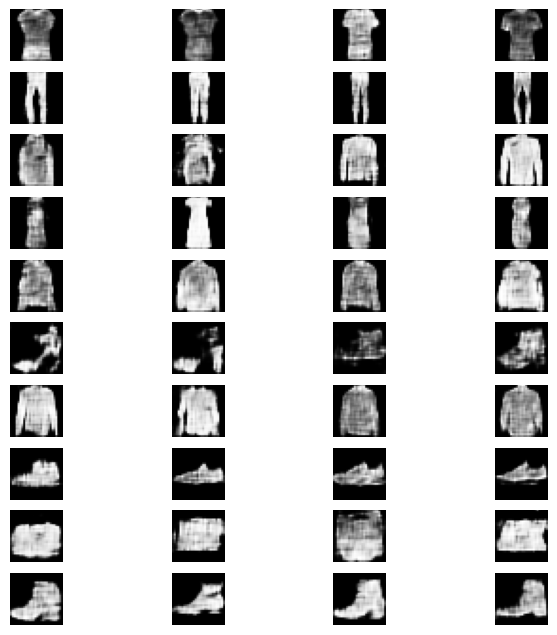

In [ ]:
device = torch.device("cpu")  # Use CPU
class_names = {
    0: 'T-shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
    4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker',
    8: 'Bag', 9: 'Ankle Boot'
}
# To generate samples
def generate_samples(generator, num_classes, latent_dim):
    fig, axes = plt.subplots(num_classes, 4, figsize=(8, 8))
    for i in range(num_classes):
        label = torch.tensor([i] * 4).to(device)  # Use .to(device) instead of .cuda()
        noise = torch.randn(4, latent_dim).to(device)  # Use .to(device)
        generated_imgs = generator(noise, label).detach().cpu()
        for j in range(4):
            axes[i, j].imshow(generated_imgs[j][0], cmap='gray')
            axes[i, j].axis("off")
    plt.show()

generate_samples(generator, num_classes, latent_dim)


In [ ]:
print("Classes displayed in order:")
for i in range(num_classes):
    print(f"Class {i}: {class_names[i]}")

Classes displayed in order:
Class 0: T-shirt
Class 1: Trouser
Class 2: Pullover
Class 3: Dress
Class 4: Coat
Class 5: Sandal
Class 6: Shirt
Class 7: Sneaker
Class 8: Bag
Class 9: Ankle Boot
